In [21]:
from typing import Tuple, Optional, Union
import math
import torch as th
import torch
import torch.nn as nn
import torchaudio as ta
from torchaudio.transforms import PSD
import torch.nn.functional as F
from Modules import STFT, mask_estimator
import matplotlib.pyplot as plt

In [22]:
from torch.utils.data import Dataset
import os
torch.manual_seed(0)

def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise

class my_dataset(Dataset):
    def __init__(self, path):
        self.path_signal = os.listdir(f'{path}/mic')
        self.path_target = f'{path}/target'
        self.path_mic = f'{path}/mic'
        self.noise = torch.rand(1,53768)
        
    def __len__(self):
        return len(self.path_signal)
    
    def __getitem__(self, idx):
        path = self.path_signal[0]
        
        target, sample_rate = ta.load(f'{self.path_target}/{path}')
        mic_array, sample_rate = ta.load(f'{self.path_mic}/{path}')
        
        target = F.pad(target, (0, mic_array.shape[-1] - target.shape[-1]))
        return  target, generate_mixture(target, self.noise, -10), mic_array

In [23]:
data_train = my_dataset('./beam_data/train')

In [24]:
train_target = data_train[0][0]
train_sample = data_train[0][2]

In [43]:
model_mask = mask_estimator()

In [26]:
fs = 16000  # Sampling frequency
window_length = int(0.025 * fs)  # 25 ms window length
window_shift = int(0.01 * fs)  # 10 ms window shift
stft = STFT(n_fft = window_length, hop=window_shift)

In [27]:
from IPython.display import Audio
Audio(train_sample, rate=16000)

In [44]:
from tqdm import tqdm
from torchvision.utils import make_grid
from torchmetrics import ScaleInvariantSignalNoiseRatio

epochs = 1000

optim = torch.optim.Adam(model_mask.parameters(), lr=5*3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optim, T_0=40
        )

si = ScaleInvariantSignalNoiseRatio()
losses = []
metrics = []

for epoch in tqdm(range(epochs)):
    optim.zero_grad()
    
    spec_sample = stft.stft(train_sample[None])
    mag = spec_sample.abs().mean(dim=1)
    phase = th.atan2(spec_sample.imag, spec_sample.real).mean(dim=1)

    mask = model_mask(spec_sample)
    mag_predict = mag * mask

    imag = mag_predict * th.sin(phase)
    real = mag_predict * th.cos(phase)

    z = th.complex(real, imag)
    wave_predict = stft.istft(z, train_sample.shape[-1])
    loss = F.mse_loss(wave_predict, train_target[None])
    
    loss.backward()
    optim.step()
    scheduler.step()
    metrics.append(si(wave_predict.detach(), train_target))
    losses.append(loss.item())
    print("Epoch [{}/{}], loss: {:.4f}, metric: {:.4f}".format(epoch+1, epochs, losses[-1], metrics[-1]))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Максим\AppData\Local\Temp\ipykernel_7620\3420453874.py:31: UserWarning: Using a target size (torch.Size([1, 1, 53768])) that is different to the input size (torch.Size([1, 53768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(wave_predict, train_target[None])
  0%|▏                                                                                | 3/1000 [00:00<00:48, 20.77it/s]

Epoch [1/1000], loss: 0.0390, metric: -12.6499
Epoch [2/1000], loss: 0.0066, metric: -13.6579
Epoch [3/1000], loss: 0.0045, metric: -17.6778
Epoch [4/1000], loss: 0.0039, metric: -21.1434


  1%|▋                                                                                | 9/1000 [00:00<00:48, 20.35it/s]

Epoch [5/1000], loss: 0.0037, metric: -23.5777
Epoch [6/1000], loss: 0.0036, metric: -25.7545
Epoch [7/1000], loss: 0.0035, metric: -28.4022
Epoch [8/1000], loss: 0.0034, metric: -31.3215
Epoch [9/1000], loss: 0.0034, metric: -34.9705


  1%|▉                                                                               | 12/1000 [00:00<00:49, 20.04it/s]

Epoch [10/1000], loss: 0.0033, metric: -41.6350
Epoch [11/1000], loss: 0.0033, metric: -62.0806
Epoch [12/1000], loss: 0.0033, metric: -39.8682
Epoch [13/1000], loss: 0.0033, metric: -34.0797
Epoch [14/1000], loss: 0.0033, metric: -30.6126


  2%|█▎                                                                              | 17/1000 [00:00<00:50, 19.33it/s]

Epoch [15/1000], loss: 0.0033, metric: -28.1846
Epoch [16/1000], loss: 0.0033, metric: -26.4298
Epoch [17/1000], loss: 0.0033, metric: -25.1513
Epoch [18/1000], loss: 0.0033, metric: -24.1977


  2%|█▋                                                                              | 21/1000 [00:01<00:51, 19.19it/s]

Epoch [19/1000], loss: 0.0033, metric: -23.4302
Epoch [20/1000], loss: 0.0033, metric: -22.8597
Epoch [21/1000], loss: 0.0033, metric: -22.4363
Epoch [22/1000], loss: 0.0033, metric: -22.0798


  3%|██                                                                              | 26/1000 [00:01<00:48, 20.20it/s]

Epoch [23/1000], loss: 0.0033, metric: -21.7676
Epoch [24/1000], loss: 0.0033, metric: -21.4986
Epoch [25/1000], loss: 0.0033, metric: -21.2628
Epoch [26/1000], loss: 0.0033, metric: -21.0459
Epoch [27/1000], loss: 0.0033, metric: -20.8416


  3%|██▍                                                                             | 31/1000 [00:01<00:50, 19.02it/s]

Epoch [28/1000], loss: 0.0033, metric: -20.6529
Epoch [29/1000], loss: 0.0033, metric: -20.4869
Epoch [30/1000], loss: 0.0033, metric: -20.3487
Epoch [31/1000], loss: 0.0033, metric: -20.2385


  4%|██▉                                                                             | 36/1000 [00:01<00:48, 19.80it/s]

Epoch [32/1000], loss: 0.0033, metric: -20.1527
Epoch [33/1000], loss: 0.0033, metric: -20.0866
Epoch [34/1000], loss: 0.0033, metric: -20.0359
Epoch [35/1000], loss: 0.0033, metric: -19.9974
Epoch [36/1000], loss: 0.0033, metric: -19.9690


  4%|███                                                                             | 38/1000 [00:01<00:49, 19.48it/s]

Epoch [37/1000], loss: 0.0033, metric: -19.9489
Epoch [38/1000], loss: 0.0033, metric: -19.9357
Epoch [39/1000], loss: 0.0033, metric: -19.9280
Epoch [40/1000], loss: 0.0033, metric: -19.9245


  4%|███▍                                                                            | 43/1000 [00:02<00:48, 19.76it/s]

Epoch [41/1000], loss: 0.0033, metric: -19.9236
Epoch [42/1000], loss: 0.0032, metric: -19.4582
Epoch [43/1000], loss: 0.0032, metric: -19.1409
Epoch [44/1000], loss: 0.0032, metric: -18.8538


  5%|███▊                                                                            | 48/1000 [00:02<00:47, 20.21it/s]

Epoch [45/1000], loss: 0.0032, metric: -18.8259
Epoch [46/1000], loss: 0.0032, metric: -18.7748
Epoch [47/1000], loss: 0.0032, metric: -18.5982
Epoch [48/1000], loss: 0.0032, metric: -18.4521
Epoch [49/1000], loss: 0.0032, metric: -18.3687


  5%|████▎                                                                           | 54/1000 [00:02<00:45, 20.64it/s]

Epoch [50/1000], loss: 0.0032, metric: -18.1980
Epoch [51/1000], loss: 0.0032, metric: -17.8763
Epoch [52/1000], loss: 0.0032, metric: -17.5676
Epoch [53/1000], loss: 0.0032, metric: -17.4752
Epoch [54/1000], loss: 0.0032, metric: -17.2877


  6%|████▌                                                                           | 57/1000 [00:02<00:47, 20.02it/s]

Epoch [55/1000], loss: 0.0032, metric: -17.0091
Epoch [56/1000], loss: 0.0032, metric: -16.7991
Epoch [57/1000], loss: 0.0032, metric: -16.6156
Epoch [58/1000], loss: 0.0032, metric: -16.4959
Epoch [59/1000], loss: 0.0032, metric: -16.3440


  6%|█████                                                                           | 63/1000 [00:03<00:47, 19.72it/s]

Epoch [60/1000], loss: 0.0032, metric: -16.1723
Epoch [61/1000], loss: 0.0032, metric: -16.0431
Epoch [62/1000], loss: 0.0032, metric: -15.9456
Epoch [63/1000], loss: 0.0032, metric: -15.8465


  7%|█████▎                                                                          | 67/1000 [00:03<00:53, 17.53it/s]

Epoch [64/1000], loss: 0.0032, metric: -15.7471
Epoch [65/1000], loss: 0.0032, metric: -15.6486
Epoch [66/1000], loss: 0.0032, metric: -15.5414
Epoch [67/1000], loss: 0.0032, metric: -15.4230
Epoch [68/1000], loss: 0.0032, metric: -15.3191


  7%|█████▊                                                                          | 72/1000 [00:03<00:50, 18.27it/s]

Epoch [69/1000], loss: 0.0032, metric: -15.2399
Epoch [70/1000], loss: 0.0032, metric: -15.1771
Epoch [71/1000], loss: 0.0032, metric: -15.1208
Epoch [72/1000], loss: 0.0032, metric: -15.0678


  8%|██████                                                                          | 76/1000 [00:03<00:51, 17.95it/s]

Epoch [73/1000], loss: 0.0032, metric: -15.0204
Epoch [74/1000], loss: 0.0032, metric: -14.9815
Epoch [75/1000], loss: 0.0032, metric: -14.9522
Epoch [76/1000], loss: 0.0032, metric: -14.9314
Epoch [77/1000], loss: 0.0032, metric: -14.9176


  8%|██████▍                                                                         | 80/1000 [00:04<00:50, 18.08it/s]

Epoch [78/1000], loss: 0.0032, metric: -14.9090
Epoch [79/1000], loss: 0.0032, metric: -14.9043
Epoch [80/1000], loss: 0.0032, metric: -14.9023
Epoch [81/1000], loss: 0.0032, metric: -14.9018
Epoch [82/1000], loss: 0.0032, metric: -14.6390


  8%|██████▊                                                                         | 85/1000 [00:04<00:50, 18.17it/s]

Epoch [83/1000], loss: 0.0032, metric: -14.3478
Epoch [84/1000], loss: 0.0032, metric: -14.3108
Epoch [85/1000], loss: 0.0032, metric: -14.0680
Epoch [86/1000], loss: 0.0032, metric: -13.8342


  9%|███████▏                                                                        | 90/1000 [00:04<00:47, 19.15it/s]

Epoch [87/1000], loss: 0.0032, metric: -13.6997
Epoch [88/1000], loss: 0.0031, metric: -13.3826
Epoch [89/1000], loss: 0.0031, metric: -13.0453
Epoch [90/1000], loss: 0.0031, metric: -12.9047


  9%|███████▌                                                                        | 94/1000 [00:04<00:48, 18.51it/s]

Epoch [91/1000], loss: 0.0031, metric: -13.0051
Epoch [92/1000], loss: 0.0031, metric: -12.9799
Epoch [93/1000], loss: 0.0031, metric: -12.7880
Epoch [94/1000], loss: 0.0031, metric: -12.4502


 10%|███████▊                                                                        | 98/1000 [00:05<00:49, 18.36it/s]

Epoch [95/1000], loss: 0.0031, metric: -12.2545
Epoch [96/1000], loss: 0.0031, metric: -12.1691
Epoch [97/1000], loss: 0.0031, metric: -11.9576
Epoch [98/1000], loss: 0.0031, metric: -11.8137


 10%|███████▉                                                                       | 100/1000 [00:05<00:50, 17.92it/s]

Epoch [99/1000], loss: 0.0031, metric: -11.6763
Epoch [100/1000], loss: 0.0031, metric: -11.4576
Epoch [101/1000], loss: 0.0031, metric: -11.2851
Epoch [102/1000], loss: 0.0031, metric: -11.2334


 10%|████████▎                                                                      | 105/1000 [00:05<00:48, 18.30it/s]

Epoch [103/1000], loss: 0.0031, metric: -11.1665
Epoch [104/1000], loss: 0.0031, metric: -11.0486
Epoch [105/1000], loss: 0.0030, metric: -10.9122
Epoch [106/1000], loss: 0.0030, metric: -10.7969
Epoch [107/1000], loss: 0.0030, metric: -10.7141


 11%|████████▌                                                                      | 109/1000 [00:05<00:47, 18.65it/s]

Epoch [108/1000], loss: 0.0030, metric: -10.6430
Epoch [109/1000], loss: 0.0030, metric: -10.5748
Epoch [110/1000], loss: 0.0030, metric: -10.5134
Epoch [111/1000], loss: 0.0030, metric: -10.4615
Epoch [112/1000], loss: 0.0030, metric: -10.4187


 12%|█████████▏                                                                     | 116/1000 [00:06<00:49, 17.84it/s]

Epoch [113/1000], loss: 0.0030, metric: -10.3843
Epoch [114/1000], loss: 0.0030, metric: -10.3578
Epoch [115/1000], loss: 0.0030, metric: -10.3383
Epoch [116/1000], loss: 0.0030, metric: -10.3244


 12%|█████████▍                                                                     | 120/1000 [00:06<00:48, 18.26it/s]

Epoch [117/1000], loss: 0.0030, metric: -10.3150
Epoch [118/1000], loss: 0.0030, metric: -10.3091
Epoch [119/1000], loss: 0.0030, metric: -10.3057
Epoch [120/1000], loss: 0.0030, metric: -10.3042


 12%|█████████▋                                                                     | 122/1000 [00:06<00:49, 17.88it/s]

Epoch [121/1000], loss: 0.0030, metric: -10.3039
Epoch [122/1000], loss: 0.0030, metric: -10.1365
Epoch [123/1000], loss: 0.0030, metric: -9.8260
Epoch [124/1000], loss: 0.0030, metric: -9.5729


 13%|██████████                                                                     | 127/1000 [00:06<00:48, 17.84it/s]

Epoch [125/1000], loss: 0.0030, metric: -9.6093
Epoch [126/1000], loss: 0.0030, metric: -9.5213
Epoch [127/1000], loss: 0.0030, metric: -9.4437
Epoch [128/1000], loss: 0.0030, metric: -9.3367


 13%|██████████▍                                                                    | 132/1000 [00:06<00:44, 19.43it/s]

Epoch [129/1000], loss: 0.0030, metric: -9.3220
Epoch [130/1000], loss: 0.0030, metric: -9.2485
Epoch [131/1000], loss: 0.0029, metric: -9.1877
Epoch [132/1000], loss: 0.0029, metric: -9.1558
Epoch [133/1000], loss: 0.0029, metric: -9.0286


 14%|██████████▋                                                                    | 136/1000 [00:07<00:48, 17.90it/s]

Epoch [134/1000], loss: 0.0029, metric: -9.0308
Epoch [135/1000], loss: 0.0029, metric: -8.9509
Epoch [136/1000], loss: 0.0029, metric: -8.9041
Epoch [137/1000], loss: 0.0029, metric: -8.8674


 14%|███████████▏                                                                   | 141/1000 [00:07<00:46, 18.61it/s]

Epoch [138/1000], loss: 0.0029, metric: -8.8983
Epoch [139/1000], loss: 0.0029, metric: -8.9143
Epoch [140/1000], loss: 0.0029, metric: -8.7896
Epoch [141/1000], loss: 0.0029, metric: -8.6605


 14%|███████████▎                                                                   | 143/1000 [00:07<00:49, 17.43it/s]

Epoch [142/1000], loss: 0.0029, metric: -8.6278
Epoch [143/1000], loss: 0.0029, metric: -8.6146
Epoch [144/1000], loss: 0.0029, metric: -8.5804
Epoch [145/1000], loss: 0.0029, metric: -8.5417


 15%|███████████▋                                                                   | 148/1000 [00:07<00:48, 17.58it/s]

Epoch [146/1000], loss: 0.0029, metric: -8.5187
Epoch [147/1000], loss: 0.0029, metric: -8.5088
Epoch [148/1000], loss: 0.0029, metric: -8.5012
Epoch [149/1000], loss: 0.0029, metric: -8.4852


 15%|████████████                                                                   | 152/1000 [00:08<00:47, 17.94it/s]

Epoch [150/1000], loss: 0.0029, metric: -8.4575
Epoch [151/1000], loss: 0.0029, metric: -8.4266
Epoch [152/1000], loss: 0.0029, metric: -8.4009
Epoch [153/1000], loss: 0.0029, metric: -8.3827


 16%|████████████▎                                                                  | 156/1000 [00:08<00:46, 18.24it/s]

Epoch [154/1000], loss: 0.0029, metric: -8.3705
Epoch [155/1000], loss: 0.0029, metric: -8.3625
Epoch [156/1000], loss: 0.0029, metric: -8.3572
Epoch [157/1000], loss: 0.0029, metric: -8.3538


 16%|████████████▋                                                                  | 161/1000 [00:08<00:43, 19.31it/s]

Epoch [158/1000], loss: 0.0029, metric: -8.3517
Epoch [159/1000], loss: 0.0029, metric: -8.3505
Epoch [160/1000], loss: 0.0029, metric: -8.3500
Epoch [161/1000], loss: 0.0029, metric: -8.3498


 16%|█████████████                                                                  | 165/1000 [00:08<00:45, 18.53it/s]

Epoch [162/1000], loss: 0.0029, metric: -8.3260
Epoch [163/1000], loss: 0.0029, metric: -8.2362
Epoch [164/1000], loss: 0.0029, metric: -8.2875
Epoch [165/1000], loss: 0.0029, metric: -8.2380
Epoch [166/1000], loss: 0.0029, metric: -8.2023


 17%|█████████████▎                                                                 | 169/1000 [00:09<00:49, 16.95it/s]

Epoch [167/1000], loss: 0.0029, metric: -8.3869
Epoch [168/1000], loss: 0.0029, metric: -8.2791
Epoch [169/1000], loss: 0.0029, metric: -8.2022
Epoch [170/1000], loss: 0.0029, metric: -8.0563


 17%|█████████████▋                                                                 | 174/1000 [00:09<00:44, 18.40it/s]

Epoch [171/1000], loss: 0.0028, metric: -7.8588
Epoch [172/1000], loss: 0.0028, metric: -7.8289
Epoch [173/1000], loss: 0.0028, metric: -7.8434
Epoch [174/1000], loss: 0.0028, metric: -7.8541


 18%|█████████████▉                                                                 | 176/1000 [00:09<00:46, 17.82it/s]

Epoch [175/1000], loss: 0.0028, metric: -7.7635
Epoch [176/1000], loss: 0.0028, metric: -7.6930
Epoch [177/1000], loss: 0.0028, metric: -7.6613
Epoch [178/1000], loss: 0.0028, metric: -7.6070


 18%|██████████████▎                                                                | 181/1000 [00:09<00:45, 18.14it/s]

Epoch [179/1000], loss: 0.0028, metric: -7.5157
Epoch [180/1000], loss: 0.0028, metric: -7.4720
Epoch [181/1000], loss: 0.0028, metric: -7.4409
Epoch [182/1000], loss: 0.0028, metric: -7.4861


 19%|██████████████▋                                                                | 186/1000 [00:09<00:43, 18.55it/s]

Epoch [183/1000], loss: 0.0028, metric: -7.4743
Epoch [184/1000], loss: 0.0028, metric: -7.4254
Epoch [185/1000], loss: 0.0028, metric: -7.3691
Epoch [186/1000], loss: 0.0028, metric: -7.3204


 19%|███████████████                                                                | 190/1000 [00:10<00:46, 17.40it/s]

Epoch [187/1000], loss: 0.0028, metric: -7.2817
Epoch [188/1000], loss: 0.0028, metric: -7.2547
Epoch [189/1000], loss: 0.0028, metric: -7.2373
Epoch [190/1000], loss: 0.0028, metric: -7.2242


 19%|███████████████▎                                                               | 194/1000 [00:10<00:46, 17.20it/s]

Epoch [191/1000], loss: 0.0028, metric: -7.2138
Epoch [192/1000], loss: 0.0028, metric: -7.2060
Epoch [193/1000], loss: 0.0028, metric: -7.2000
Epoch [194/1000], loss: 0.0028, metric: -7.1951


 20%|███████████████▌                                                               | 197/1000 [00:10<00:41, 19.13it/s]

Epoch [195/1000], loss: 0.0028, metric: -7.1911
Epoch [196/1000], loss: 0.0028, metric: -7.1881
Epoch [197/1000], loss: 0.0028, metric: -7.1858
Epoch [198/1000], loss: 0.0028, metric: -7.1844


 20%|███████████████▉                                                               | 201/1000 [00:10<00:45, 17.74it/s]

Epoch [199/1000], loss: 0.0028, metric: -7.1835
Epoch [200/1000], loss: 0.0028, metric: -7.1831
Epoch [201/1000], loss: 0.0028, metric: -7.1830
Epoch [202/1000], loss: 0.0028, metric: -7.1882


 20%|████████████████▏                                                              | 205/1000 [00:11<00:44, 17.82it/s]

Epoch [203/1000], loss: 0.0028, metric: -7.0802
Epoch [204/1000], loss: 0.0028, metric: -7.1405
Epoch [205/1000], loss: 0.0028, metric: -6.9176
Epoch [206/1000], loss: 0.0027, metric: -6.8876


 21%|████████████████▌                                                              | 209/1000 [00:11<00:43, 18.26it/s]

Epoch [207/1000], loss: 0.0028, metric: -7.3125
Epoch [208/1000], loss: 0.0027, metric: -7.0799
Epoch [209/1000], loss: 0.0027, metric: -6.9255
Epoch [210/1000], loss: 0.0028, metric: -6.9553


 21%|████████████████▊                                                              | 213/1000 [00:11<00:44, 17.85it/s]

Epoch [211/1000], loss: 0.0027, metric: -6.6606
Epoch [212/1000], loss: 0.0027, metric: -7.0259
Epoch [213/1000], loss: 0.0027, metric: -6.6939
Epoch [214/1000], loss: 0.0027, metric: -6.5554


 22%|█████████████████▏                                                             | 218/1000 [00:11<00:43, 18.09it/s]

Epoch [215/1000], loss: 0.0027, metric: -6.6071
Epoch [216/1000], loss: 0.0027, metric: -6.6620
Epoch [217/1000], loss: 0.0027, metric: -6.6524
Epoch [218/1000], loss: 0.0027, metric: -6.6274


 22%|█████████████████▌                                                             | 222/1000 [00:12<00:45, 17.02it/s]

Epoch [219/1000], loss: 0.0027, metric: -6.5113
Epoch [220/1000], loss: 0.0027, metric: -6.4042
Epoch [221/1000], loss: 0.0027, metric: -6.3996
Epoch [222/1000], loss: 0.0027, metric: -6.4596


 23%|█████████████████▊                                                             | 226/1000 [00:12<00:44, 17.22it/s]

Epoch [223/1000], loss: 0.0027, metric: -6.4374
Epoch [224/1000], loss: 0.0027, metric: -6.3699
Epoch [225/1000], loss: 0.0027, metric: -6.2836
Epoch [226/1000], loss: 0.0027, metric: -6.2021


 23%|██████████████████                                                             | 228/1000 [00:12<00:44, 17.29it/s]

Epoch [227/1000], loss: 0.0027, metric: -6.1583
Epoch [228/1000], loss: 0.0027, metric: -6.1430
Epoch [229/1000], loss: 0.0027, metric: -6.1389
Epoch [230/1000], loss: 0.0027, metric: -6.1343


 23%|██████████████████▍                                                            | 234/1000 [00:12<00:41, 18.58it/s]

Epoch [231/1000], loss: 0.0027, metric: -6.1224
Epoch [232/1000], loss: 0.0027, metric: -6.1048
Epoch [233/1000], loss: 0.0026, metric: -6.0862
Epoch [234/1000], loss: 0.0026, metric: -6.0695


 24%|██████████████████▋                                                            | 237/1000 [00:12<00:38, 19.73it/s]

Epoch [235/1000], loss: 0.0026, metric: -6.0562
Epoch [236/1000], loss: 0.0026, metric: -6.0464
Epoch [237/1000], loss: 0.0026, metric: -6.0398
Epoch [238/1000], loss: 0.0026, metric: -6.0358
Epoch [239/1000], loss: 0.0026, metric: -6.0335


 24%|███████████████████▏                                                           | 243/1000 [00:13<00:40, 18.87it/s]

Epoch [240/1000], loss: 0.0026, metric: -6.0326
Epoch [241/1000], loss: 0.0026, metric: -6.0323
Epoch [242/1000], loss: 0.0027, metric: -6.2725
Epoch [243/1000], loss: 0.0027, metric: -6.1627


 25%|███████████████████▌                                                           | 247/1000 [00:13<00:42, 17.86it/s]

Epoch [244/1000], loss: 0.0027, metric: -6.1369
Epoch [245/1000], loss: 0.0026, metric: -6.0431
Epoch [246/1000], loss: 0.0027, metric: -6.1900
Epoch [247/1000], loss: 0.0027, metric: -6.1582


 25%|███████████████████▊                                                           | 250/1000 [00:13<00:38, 19.51it/s]

Epoch [248/1000], loss: 0.0026, metric: -5.8582
Epoch [249/1000], loss: 0.0026, metric: -5.8420
Epoch [250/1000], loss: 0.0026, metric: -6.0882
Epoch [251/1000], loss: 0.0026, metric: -5.8201
Epoch [252/1000], loss: 0.0026, metric: -5.7683


 26%|████████████████████▏                                                          | 256/1000 [00:13<00:36, 20.57it/s]

Epoch [253/1000], loss: 0.0026, metric: -5.8568
Epoch [254/1000], loss: 0.0026, metric: -5.9576
Epoch [255/1000], loss: 0.0026, metric: -5.9044
Epoch [256/1000], loss: 0.0026, metric: -5.8247
Epoch [257/1000], loss: 0.0026, metric: -5.7368


 26%|████████████████████▍                                                          | 259/1000 [00:13<00:36, 20.56it/s]

Epoch [258/1000], loss: 0.0026, metric: -5.6416
Epoch [259/1000], loss: 0.0026, metric: -5.5789
Epoch [260/1000], loss: 0.0026, metric: -5.5370
Epoch [261/1000], loss: 0.0026, metric: -5.5367


 26%|████████████████████▉                                                          | 265/1000 [00:14<00:36, 19.99it/s]

Epoch [262/1000], loss: 0.0026, metric: -5.5260
Epoch [263/1000], loss: 0.0026, metric: -5.5193
Epoch [264/1000], loss: 0.0026, metric: -5.5153
Epoch [265/1000], loss: 0.0026, metric: -5.4952
Epoch [266/1000], loss: 0.0026, metric: -5.4704


 27%|█████████████████████▏                                                         | 268/1000 [00:14<00:40, 18.16it/s]

Epoch [267/1000], loss: 0.0026, metric: -5.4525
Epoch [268/1000], loss: 0.0026, metric: -5.4421
Epoch [269/1000], loss: 0.0026, metric: -5.4357


 27%|█████████████████████▌                                                         | 273/1000 [00:14<00:38, 18.85it/s]

Epoch [270/1000], loss: 0.0026, metric: -5.4297
Epoch [271/1000], loss: 0.0026, metric: -5.4211
Epoch [272/1000], loss: 0.0026, metric: -5.4106
Epoch [273/1000], loss: 0.0026, metric: -5.4009
Epoch [274/1000], loss: 0.0026, metric: -5.3937


 28%|█████████████████████▉                                                         | 278/1000 [00:14<00:37, 19.45it/s]

Epoch [275/1000], loss: 0.0026, metric: -5.3889
Epoch [276/1000], loss: 0.0026, metric: -5.3860
Epoch [277/1000], loss: 0.0026, metric: -5.3844
Epoch [278/1000], loss: 0.0026, metric: -5.3835
Epoch [279/1000], loss: 0.0026, metric: -5.3832


 28%|██████████████████████▍                                                        | 284/1000 [00:15<00:34, 20.47it/s]

Epoch [280/1000], loss: 0.0026, metric: -5.3830
Epoch [281/1000], loss: 0.0026, metric: -5.3830
Epoch [282/1000], loss: 0.0026, metric: -5.4894
Epoch [283/1000], loss: 0.0026, metric: -5.4371
Epoch [284/1000], loss: 0.0026, metric: -5.5340


 29%|██████████████████████▋                                                        | 287/1000 [00:15<00:34, 20.51it/s]

Epoch [285/1000], loss: 0.0026, metric: -5.4259
Epoch [286/1000], loss: 0.0026, metric: -5.3891
Epoch [287/1000], loss: 0.0026, metric: -5.3500
Epoch [288/1000], loss: 0.0026, metric: -5.4735
Epoch [289/1000], loss: 0.0026, metric: -5.4886


 29%|███████████████████████▏                                                       | 293/1000 [00:15<00:34, 20.52it/s]

Epoch [290/1000], loss: 0.0026, metric: -5.4675
Epoch [291/1000], loss: 0.0026, metric: -5.4962
Epoch [292/1000], loss: 0.0026, metric: -5.4374
Epoch [293/1000], loss: 0.0026, metric: -5.3169


 30%|███████████████████████▍                                                       | 296/1000 [00:15<00:36, 19.47it/s]

Epoch [294/1000], loss: 0.0026, metric: -5.2583
Epoch [295/1000], loss: 0.0026, metric: -5.2641
Epoch [296/1000], loss: 0.0026, metric: -5.2668
Epoch [297/1000], loss: 0.0026, metric: -5.2687


 30%|███████████████████████▋                                                       | 300/1000 [00:16<00:37, 18.82it/s]

Epoch [298/1000], loss: 0.0026, metric: -5.2550
Epoch [299/1000], loss: 0.0025, metric: -5.2331
Epoch [300/1000], loss: 0.0025, metric: -5.2739
Epoch [301/1000], loss: 0.0025, metric: -5.2566
Epoch [302/1000], loss: 0.0025, metric: -5.2380


 31%|████████████████████████▏                                                      | 306/1000 [00:16<00:33, 20.49it/s]

Epoch [303/1000], loss: 0.0025, metric: -5.2444
Epoch [304/1000], loss: 0.0025, metric: -5.2208
Epoch [305/1000], loss: 0.0025, metric: -5.1565
Epoch [306/1000], loss: 0.0025, metric: -5.0911


 31%|████████████████████████▍                                                      | 309/1000 [00:16<00:37, 18.54it/s]

Epoch [307/1000], loss: 0.0025, metric: -5.0482
Epoch [308/1000], loss: 0.0025, metric: -5.0272
Epoch [309/1000], loss: 0.0025, metric: -5.0227
Epoch [310/1000], loss: 0.0025, metric: -5.0269


 31%|████████████████████████▊                                                      | 314/1000 [00:16<00:35, 19.56it/s]

Epoch [311/1000], loss: 0.0025, metric: -5.0323
Epoch [312/1000], loss: 0.0025, metric: -5.0358
Epoch [313/1000], loss: 0.0025, metric: -5.0375
Epoch [314/1000], loss: 0.0025, metric: -5.0382


 32%|█████████████████████████                                                      | 317/1000 [00:16<00:35, 19.21it/s]

Epoch [315/1000], loss: 0.0025, metric: -5.0380
Epoch [316/1000], loss: 0.0025, metric: -5.0369
Epoch [317/1000], loss: 0.0025, metric: -5.0350
Epoch [318/1000], loss: 0.0025, metric: -5.0331


 32%|█████████████████████████▍                                                     | 322/1000 [00:17<00:35, 19.12it/s]

Epoch [319/1000], loss: 0.0025, metric: -5.0315
Epoch [320/1000], loss: 0.0025, metric: -5.0305
Epoch [321/1000], loss: 0.0025, metric: -5.0303
Epoch [322/1000], loss: 0.0025, metric: -5.0380
Epoch [323/1000], loss: 0.0025, metric: -5.0806


 33%|█████████████████████████▊                                                     | 327/1000 [00:17<00:34, 19.46it/s]

Epoch [324/1000], loss: 0.0025, metric: -5.0183
Epoch [325/1000], loss: 0.0025, metric: -5.1409
Epoch [326/1000], loss: 0.0025, metric: -5.0215
Epoch [327/1000], loss: 0.0025, metric: -4.9267
Epoch [328/1000], loss: 0.0025, metric: -4.9116


 33%|██████████████████████████▎                                                    | 333/1000 [00:17<00:31, 21.05it/s]

Epoch [329/1000], loss: 0.0025, metric: -4.8568
Epoch [330/1000], loss: 0.0025, metric: -4.8510
Epoch [331/1000], loss: 0.0025, metric: -4.8435
Epoch [332/1000], loss: 0.0025, metric: -4.7926
Epoch [333/1000], loss: 0.0025, metric: -4.7740


 34%|██████████████████████████▌                                                    | 336/1000 [00:17<00:34, 19.03it/s]

Epoch [334/1000], loss: 0.0025, metric: -4.7243
Epoch [335/1000], loss: 0.0025, metric: -4.6650
Epoch [336/1000], loss: 0.0025, metric: -4.6561
Epoch [337/1000], loss: 0.0025, metric: -4.6837


 34%|██████████████████████████▊                                                    | 340/1000 [00:18<00:34, 18.92it/s]

Epoch [338/1000], loss: 0.0025, metric: -4.6472
Epoch [339/1000], loss: 0.0025, metric: -4.6052
Epoch [340/1000], loss: 0.0025, metric: -4.5796
Epoch [341/1000], loss: 0.0025, metric: -4.5602


 34%|███████████████████████████▎                                                   | 345/1000 [00:18<00:32, 20.25it/s]

Epoch [342/1000], loss: 0.0025, metric: -4.5632
Epoch [343/1000], loss: 0.0025, metric: -4.5584
Epoch [344/1000], loss: 0.0025, metric: -4.5512
Epoch [345/1000], loss: 0.0025, metric: -4.5449
Epoch [346/1000], loss: 0.0025, metric: -4.5346


 35%|███████████████████████████▋                                                   | 351/1000 [00:18<00:32, 20.12it/s]

Epoch [347/1000], loss: 0.0025, metric: -4.5203
Epoch [348/1000], loss: 0.0025, metric: -4.5061
Epoch [349/1000], loss: 0.0025, metric: -4.4969
Epoch [350/1000], loss: 0.0025, metric: -4.4901
Epoch [351/1000], loss: 0.0025, metric: -4.4841


 35%|███████████████████████████▉                                                   | 354/1000 [00:18<00:32, 20.11it/s]

Epoch [352/1000], loss: 0.0025, metric: -4.4795
Epoch [353/1000], loss: 0.0025, metric: -4.4766
Epoch [354/1000], loss: 0.0024, metric: -4.4747
Epoch [355/1000], loss: 0.0024, metric: -4.4732
Epoch [356/1000], loss: 0.0024, metric: -4.4719


 36%|████████████████████████████▎                                                  | 359/1000 [00:19<00:33, 18.97it/s]

Epoch [357/1000], loss: 0.0024, metric: -4.4708
Epoch [358/1000], loss: 0.0024, metric: -4.4700
Epoch [359/1000], loss: 0.0024, metric: -4.4694
Epoch [360/1000], loss: 0.0024, metric: -4.4691


 36%|████████████████████████████▌                                                  | 362/1000 [00:19<00:31, 20.36it/s]

Epoch [361/1000], loss: 0.0024, metric: -4.4691
Epoch [362/1000], loss: 0.0025, metric: -4.4830
Epoch [363/1000], loss: 0.0025, metric: -4.5066
Epoch [364/1000], loss: 0.0024, metric: -4.5411
Epoch [365/1000], loss: 0.0025, metric: -4.5747


 37%|█████████████████████████████                                                  | 368/1000 [00:19<00:33, 18.65it/s]

Epoch [366/1000], loss: 0.0025, metric: -4.5172
Epoch [367/1000], loss: 0.0025, metric: -4.4838
Epoch [368/1000], loss: 0.0024, metric: -4.4955
Epoch [369/1000], loss: 0.0025, metric: -4.7481


 37%|█████████████████████████████▍                                                 | 373/1000 [00:19<00:32, 19.52it/s]

Epoch [370/1000], loss: 0.0025, metric: -4.4524
Epoch [371/1000], loss: 0.0025, metric: -4.4325
Epoch [372/1000], loss: 0.0024, metric: -4.3589
Epoch [373/1000], loss: 0.0024, metric: -4.3667


 38%|█████████████████████████████▊                                                 | 377/1000 [00:20<00:33, 18.81it/s]

Epoch [374/1000], loss: 0.0024, metric: -4.4604
Epoch [375/1000], loss: 0.0024, metric: -4.4649
Epoch [376/1000], loss: 0.0024, metric: -4.4994
Epoch [377/1000], loss: 0.0024, metric: -4.4281


 38%|█████████████████████████████▉                                                 | 379/1000 [00:20<00:33, 18.45it/s]

Epoch [378/1000], loss: 0.0024, metric: -4.3436
Epoch [379/1000], loss: 0.0024, metric: -4.3047
Epoch [380/1000], loss: 0.0024, metric: -4.2892
Epoch [381/1000], loss: 0.0024, metric: -4.2842


 38%|██████████████████████████████▍                                                | 385/1000 [00:20<00:30, 20.24it/s]

Epoch [382/1000], loss: 0.0024, metric: -4.3184
Epoch [383/1000], loss: 0.0024, metric: -4.3394
Epoch [384/1000], loss: 0.0024, metric: -4.3041
Epoch [385/1000], loss: 0.0024, metric: -4.2745
Epoch [386/1000], loss: 0.0024, metric: -4.2661


 39%|██████████████████████████████▋                                                | 388/1000 [00:20<00:28, 21.35it/s]

Epoch [387/1000], loss: 0.0024, metric: -4.2535
Epoch [388/1000], loss: 0.0024, metric: -4.2291
Epoch [389/1000], loss: 0.0024, metric: -4.2098
Epoch [390/1000], loss: 0.0024, metric: -4.2038
Epoch [391/1000], loss: 0.0024, metric: -4.2031


 39%|███████████████████████████████▏                                               | 394/1000 [00:20<00:28, 21.37it/s]

Epoch [392/1000], loss: 0.0024, metric: -4.2019
Epoch [393/1000], loss: 0.0024, metric: -4.1999
Epoch [394/1000], loss: 0.0024, metric: -4.1975
Epoch [395/1000], loss: 0.0024, metric: -4.1949


 40%|███████████████████████████████▌                                               | 399/1000 [00:21<00:31, 19.27it/s]

Epoch [396/1000], loss: 0.0024, metric: -4.1924
Epoch [397/1000], loss: 0.0024, metric: -4.1903
Epoch [398/1000], loss: 0.0024, metric: -4.1889
Epoch [399/1000], loss: 0.0024, metric: -4.1881


 40%|███████████████████████████████▊                                               | 402/1000 [00:21<00:31, 19.03it/s]

Epoch [400/1000], loss: 0.0024, metric: -4.1878
Epoch [401/1000], loss: 0.0024, metric: -4.1877
Epoch [402/1000], loss: 0.0024, metric: -4.2659
Epoch [403/1000], loss: 0.0024, metric: -4.3140
Epoch [404/1000], loss: 0.0024, metric: -4.4197


 41%|████████████████████████████████▏                                              | 408/1000 [00:21<00:29, 19.82it/s]

Epoch [405/1000], loss: 0.0024, metric: -4.3111
Epoch [406/1000], loss: 0.0024, metric: -4.2422
Epoch [407/1000], loss: 0.0024, metric: -4.1983
Epoch [408/1000], loss: 0.0024, metric: -4.1892
Epoch [409/1000], loss: 0.0024, metric: -4.2195


 41%|████████████████████████████████▍                                              | 411/1000 [00:21<00:28, 20.69it/s]

Epoch [410/1000], loss: 0.0024, metric: -4.4327
Epoch [411/1000], loss: 0.0024, metric: -4.3628
Epoch [412/1000], loss: 0.0024, metric: -4.1419
Epoch [413/1000], loss: 0.0024, metric: -4.1283


 42%|████████████████████████████████▉                                              | 417/1000 [00:22<00:29, 19.52it/s]

Epoch [414/1000], loss: 0.0024, metric: -4.0904
Epoch [415/1000], loss: 0.0024, metric: -4.1551
Epoch [416/1000], loss: 0.0024, metric: -4.2201
Epoch [417/1000], loss: 0.0024, metric: -4.2321


 42%|█████████████████████████████████▏                                             | 420/1000 [00:22<00:29, 19.81it/s]

Epoch [418/1000], loss: 0.0024, metric: -4.2556
Epoch [419/1000], loss: 0.0024, metric: -4.2479
Epoch [420/1000], loss: 0.0024, metric: -4.1990
Epoch [421/1000], loss: 0.0024, metric: -4.1210
Epoch [422/1000], loss: 0.0024, metric: -4.0670


 42%|█████████████████████████████████▍                                             | 424/1000 [00:22<00:29, 19.56it/s]

Epoch [423/1000], loss: 0.0024, metric: -4.0562
Epoch [424/1000], loss: 0.0024, metric: -4.0647
Epoch [425/1000], loss: 0.0024, metric: -4.0751
Epoch [426/1000], loss: 0.0024, metric: -4.0779


 43%|█████████████████████████████████▉                                             | 430/1000 [00:22<00:28, 20.04it/s]

Epoch [427/1000], loss: 0.0024, metric: -4.0851
Epoch [428/1000], loss: 0.0024, metric: -4.1057
Epoch [429/1000], loss: 0.0024, metric: -4.1274
Epoch [430/1000], loss: 0.0024, metric: -4.1386
Epoch [431/1000], loss: 0.0024, metric: -4.1400


 44%|██████████████████████████████████▎                                            | 435/1000 [00:23<00:29, 19.02it/s]

Epoch [432/1000], loss: 0.0024, metric: -4.1357
Epoch [433/1000], loss: 0.0024, metric: -4.1284
Epoch [434/1000], loss: 0.0024, metric: -4.1201
Epoch [435/1000], loss: 0.0024, metric: -4.1125


 44%|██████████████████████████████████▌                                            | 438/1000 [00:23<00:28, 19.71it/s]

Epoch [436/1000], loss: 0.0024, metric: -4.1065
Epoch [437/1000], loss: 0.0024, metric: -4.1023
Epoch [438/1000], loss: 0.0024, metric: -4.0997
Epoch [439/1000], loss: 0.0024, metric: -4.0982


 44%|██████████████████████████████████▉                                            | 443/1000 [00:23<00:29, 19.05it/s]

Epoch [440/1000], loss: 0.0024, metric: -4.0976
Epoch [441/1000], loss: 0.0024, metric: -4.0975
Epoch [442/1000], loss: 0.0024, metric: -4.1101
Epoch [443/1000], loss: 0.0024, metric: -4.0779
Epoch [444/1000], loss: 0.0024, metric: -4.1997


 45%|███████████████████████████████████▎                                           | 447/1000 [00:23<00:28, 19.31it/s]

Epoch [445/1000], loss: 0.0024, metric: -4.2331
Epoch [446/1000], loss: 0.0024, metric: -4.2095
Epoch [447/1000], loss: 0.0024, metric: -4.2905
Epoch [448/1000], loss: 0.0024, metric: -4.3971


 45%|███████████████████████████████████▋                                           | 452/1000 [00:23<00:28, 19.12it/s]

Epoch [449/1000], loss: 0.0024, metric: -4.3229
Epoch [450/1000], loss: 0.0024, metric: -4.2001
Epoch [451/1000], loss: 0.0024, metric: -4.1738
Epoch [452/1000], loss: 0.0024, metric: -4.0943
Epoch [453/1000], loss: 0.0024, metric: -4.0924


 46%|████████████████████████████████████                                           | 457/1000 [00:24<00:28, 19.39it/s]

Epoch [454/1000], loss: 0.0024, metric: -4.2160
Epoch [455/1000], loss: 0.0024, metric: -4.2453
Epoch [456/1000], loss: 0.0024, metric: -4.1944
Epoch [457/1000], loss: 0.0024, metric: -4.1655
Epoch [458/1000], loss: 0.0024, metric: -4.1441


 46%|████████████████████████████████████▎                                          | 460/1000 [00:24<00:27, 19.78it/s]

Epoch [459/1000], loss: 0.0024, metric: -4.1197
Epoch [460/1000], loss: 0.0024, metric: -4.1048
Epoch [461/1000], loss: 0.0024, metric: -4.0793
Epoch [462/1000], loss: 0.0024, metric: -4.0598


 47%|████████████████████████████████████▊                                          | 466/1000 [00:24<00:26, 20.03it/s]

Epoch [463/1000], loss: 0.0024, metric: -4.0496
Epoch [464/1000], loss: 0.0024, metric: -4.0410
Epoch [465/1000], loss: 0.0024, metric: -4.0393
Epoch [466/1000], loss: 0.0024, metric: -4.0310


 47%|█████████████████████████████████████                                          | 469/1000 [00:24<00:27, 19.49it/s]

Epoch [467/1000], loss: 0.0024, metric: -4.0163
Epoch [468/1000], loss: 0.0024, metric: -4.0056
Epoch [469/1000], loss: 0.0024, metric: -4.0020
Epoch [470/1000], loss: 0.0024, metric: -3.9998


 47%|█████████████████████████████████████▍                                         | 474/1000 [00:25<00:27, 18.91it/s]

Epoch [471/1000], loss: 0.0024, metric: -3.9953
Epoch [472/1000], loss: 0.0024, metric: -3.9887
Epoch [473/1000], loss: 0.0024, metric: -3.9812
Epoch [474/1000], loss: 0.0024, metric: -3.9737


 48%|█████████████████████████████████████▊                                         | 479/1000 [00:25<00:26, 20.00it/s]

Epoch [475/1000], loss: 0.0024, metric: -3.9673
Epoch [476/1000], loss: 0.0024, metric: -3.9625
Epoch [477/1000], loss: 0.0024, metric: -3.9593
Epoch [478/1000], loss: 0.0024, metric: -3.9574
Epoch [479/1000], loss: 0.0024, metric: -3.9564


 48%|██████████████████████████████████████                                         | 482/1000 [00:25<00:25, 20.60it/s]

Epoch [480/1000], loss: 0.0024, metric: -3.9560
Epoch [481/1000], loss: 0.0024, metric: -3.9559
Epoch [482/1000], loss: 0.0024, metric: -3.9579
Epoch [483/1000], loss: 0.0024, metric: -3.9575


 49%|██████████████████████████████████████▌                                        | 488/1000 [00:25<00:25, 20.40it/s]

Epoch [484/1000], loss: 0.0024, metric: -4.0527
Epoch [485/1000], loss: 0.0024, metric: -4.0387
Epoch [486/1000], loss: 0.0024, metric: -4.1179
Epoch [487/1000], loss: 0.0024, metric: -4.1261
Epoch [488/1000], loss: 0.0024, metric: -4.1325


 49%|██████████████████████████████████████▊                                        | 491/1000 [00:25<00:25, 20.14it/s]

Epoch [489/1000], loss: 0.0024, metric: -4.0530
Epoch [490/1000], loss: 0.0024, metric: -3.9803
Epoch [491/1000], loss: 0.0024, metric: -3.9139
Epoch [492/1000], loss: 0.0024, metric: -3.9614


 49%|███████████████████████████████████████                                        | 494/1000 [00:26<00:27, 18.61it/s]

Epoch [493/1000], loss: 0.0024, metric: -4.0600
Epoch [494/1000], loss: 0.0024, metric: -4.0727
Epoch [495/1000], loss: 0.0024, metric: -3.9551
Epoch [496/1000], loss: 0.0024, metric: -3.9288
Epoch [497/1000], loss: 0.0024, metric: -3.9164


 50%|███████████████████████████████████████▍                                       | 499/1000 [00:26<00:26, 19.22it/s]

Epoch [498/1000], loss: 0.0024, metric: -3.9225
Epoch [499/1000], loss: 0.0024, metric: -3.8650
Epoch [500/1000], loss: 0.0024, metric: -3.8450
Epoch [501/1000], loss: 0.0024, metric: -3.8237


 50%|███████████████████████████████████████▉                                       | 505/1000 [00:26<00:25, 19.48it/s]

Epoch [502/1000], loss: 0.0024, metric: -3.8140
Epoch [503/1000], loss: 0.0024, metric: -3.8315
Epoch [504/1000], loss: 0.0024, metric: -3.8532
Epoch [505/1000], loss: 0.0024, metric: -3.8599


 51%|████████████████████████████████████████▏                                      | 508/1000 [00:26<00:24, 20.47it/s]

Epoch [506/1000], loss: 0.0024, metric: -3.8488
Epoch [507/1000], loss: 0.0024, metric: -3.8417
Epoch [508/1000], loss: 0.0024, metric: -3.8465
Epoch [509/1000], loss: 0.0024, metric: -3.8499
Epoch [510/1000], loss: 0.0024, metric: -3.8434


 51%|████████████████████████████████████████▎                                      | 511/1000 [00:26<00:23, 20.42it/s]

Epoch [511/1000], loss: 0.0024, metric: -3.8326
Epoch [512/1000], loss: 0.0024, metric: -3.8230
Epoch [513/1000], loss: 0.0024, metric: -3.8158
Epoch [514/1000], loss: 0.0024, metric: -3.8107


 52%|████████████████████████████████████████▊                                      | 517/1000 [00:27<00:24, 19.97it/s]

Epoch [515/1000], loss: 0.0024, metric: -3.8071
Epoch [516/1000], loss: 0.0024, metric: -3.8047
Epoch [517/1000], loss: 0.0024, metric: -3.8031
Epoch [518/1000], loss: 0.0024, metric: -3.8021
Epoch [519/1000], loss: 0.0024, metric: -3.8015


 52%|█████████████████████████████████████████▏                                     | 522/1000 [00:27<00:25, 18.91it/s]

Epoch [520/1000], loss: 0.0024, metric: -3.8012
Epoch [521/1000], loss: 0.0024, metric: -3.8011
Epoch [522/1000], loss: 0.0024, metric: -3.8626
Epoch [523/1000], loss: 0.0024, metric: -3.8112


 53%|█████████████████████████████████████████▌                                     | 526/1000 [00:27<00:26, 18.16it/s]

Epoch [524/1000], loss: 0.0024, metric: -3.9011
Epoch [525/1000], loss: 0.0024, metric: -3.9447
Epoch [526/1000], loss: 0.0024, metric: -3.8590
Epoch [527/1000], loss: 0.0024, metric: -3.7941
Epoch [528/1000], loss: 0.0024, metric: -3.8259


 53%|█████████████████████████████████████████▉                                     | 531/1000 [00:27<00:24, 19.51it/s]

Epoch [529/1000], loss: 0.0024, metric: -3.8195
Epoch [530/1000], loss: 0.0024, metric: -3.9115
Epoch [531/1000], loss: 0.0024, metric: -3.9118
Epoch [532/1000], loss: 0.0024, metric: -3.8442
Epoch [533/1000], loss: 0.0024, metric: -3.9043


 54%|██████████████████████████████████████████▎                                    | 536/1000 [00:28<00:23, 19.68it/s]

Epoch [534/1000], loss: 0.0024, metric: -3.8915
Epoch [535/1000], loss: 0.0024, metric: -3.8262
Epoch [536/1000], loss: 0.0023, metric: -3.7978
Epoch [537/1000], loss: 0.0023, metric: -3.7627
Epoch [538/1000], loss: 0.0023, metric: -3.7635


 54%|██████████████████████████████████████████▋                                    | 541/1000 [00:28<00:23, 19.79it/s]

Epoch [539/1000], loss: 0.0023, metric: -3.7568
Epoch [540/1000], loss: 0.0023, metric: -3.7567
Epoch [541/1000], loss: 0.0023, metric: -3.7487
Epoch [542/1000], loss: 0.0023, metric: -3.7246
Epoch [543/1000], loss: 0.0023, metric: -3.6991


 55%|███████████████████████████████████████████▏                                   | 547/1000 [00:28<00:21, 21.04it/s]

Epoch [544/1000], loss: 0.0023, metric: -3.6925
Epoch [545/1000], loss: 0.0023, metric: -3.6907
Epoch [546/1000], loss: 0.0023, metric: -3.6837
Epoch [547/1000], loss: 0.0023, metric: -3.6712
Epoch [548/1000], loss: 0.0023, metric: -3.6630


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:28<00:23, 19.52it/s]

Epoch [549/1000], loss: 0.0023, metric: -3.6622
Epoch [550/1000], loss: 0.0023, metric: -3.6646
Epoch [551/1000], loss: 0.0023, metric: -3.6681
Epoch [552/1000], loss: 0.0023, metric: -3.6715
Epoch [553/1000], loss: 0.0023, metric: -3.6736


 56%|███████████████████████████████████████████▉                                   | 556/1000 [00:29<00:22, 19.90it/s]

Epoch [554/1000], loss: 0.0023, metric: -3.6739
Epoch [555/1000], loss: 0.0023, metric: -3.6726
Epoch [556/1000], loss: 0.0023, metric: -3.6706
Epoch [557/1000], loss: 0.0023, metric: -3.6685


 56%|████████████████████████████████████████████▍                                  | 562/1000 [00:29<00:21, 20.51it/s]

Epoch [558/1000], loss: 0.0023, metric: -3.6668
Epoch [559/1000], loss: 0.0023, metric: -3.6656
Epoch [560/1000], loss: 0.0023, metric: -3.6650
Epoch [561/1000], loss: 0.0023, metric: -3.6649
Epoch [562/1000], loss: 0.0023, metric: -3.6414


 56%|████████████████████████████████████████████▋                                  | 565/1000 [00:29<00:21, 20.09it/s]

Epoch [563/1000], loss: 0.0023, metric: -3.6562
Epoch [564/1000], loss: 0.0023, metric: -3.7796
Epoch [565/1000], loss: 0.0024, metric: -3.9252
Epoch [566/1000], loss: 0.0023, metric: -3.7214


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:29<00:21, 19.61it/s]

Epoch [567/1000], loss: 0.0023, metric: -3.7683
Epoch [568/1000], loss: 0.0023, metric: -3.6748
Epoch [569/1000], loss: 0.0023, metric: -3.7350
Epoch [570/1000], loss: 0.0024, metric: -3.8870
Epoch [571/1000], loss: 0.0023, metric: -3.7188


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [00:30<00:20, 20.36it/s]

Epoch [572/1000], loss: 0.0023, metric: -3.7818
Epoch [573/1000], loss: 0.0023, metric: -3.6949
Epoch [574/1000], loss: 0.0023, metric: -3.7072
Epoch [575/1000], loss: 0.0023, metric: -3.7954
Epoch [576/1000], loss: 0.0023, metric: -3.6691


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [00:30<00:20, 20.36it/s]

Epoch [577/1000], loss: 0.0023, metric: -3.6714
Epoch [578/1000], loss: 0.0023, metric: -3.7051
Epoch [579/1000], loss: 0.0023, metric: -3.6789
Epoch [580/1000], loss: 0.0023, metric: -3.6718


 58%|██████████████████████████████████████████████▏                                | 584/1000 [00:30<00:20, 20.55it/s]

Epoch [581/1000], loss: 0.0023, metric: -3.6528
Epoch [582/1000], loss: 0.0023, metric: -3.6786
Epoch [583/1000], loss: 0.0023, metric: -3.6893
Epoch [584/1000], loss: 0.0023, metric: -3.6690
Epoch [585/1000], loss: 0.0023, metric: -3.6417


 59%|██████████████████████████████████████████████▌                                | 589/1000 [00:30<00:21, 19.26it/s]

Epoch [586/1000], loss: 0.0023, metric: -3.6213
Epoch [587/1000], loss: 0.0023, metric: -3.6141
Epoch [588/1000], loss: 0.0023, metric: -3.6179
Epoch [589/1000], loss: 0.0023, metric: -3.6261
Epoch [590/1000], loss: 0.0023, metric: -3.6287


 59%|██████████████████████████████████████████████▊                                | 593/1000 [00:31<00:22, 18.46it/s]

Epoch [591/1000], loss: 0.0023, metric: -3.6231
Epoch [592/1000], loss: 0.0023, metric: -3.6127
Epoch [593/1000], loss: 0.0023, metric: -3.6027
Epoch [594/1000], loss: 0.0023, metric: -3.5960


 60%|███████████████████████████████████████████████▏                               | 598/1000 [00:31<00:20, 20.00it/s]

Epoch [595/1000], loss: 0.0023, metric: -3.5927
Epoch [596/1000], loss: 0.0023, metric: -3.5916
Epoch [597/1000], loss: 0.0023, metric: -3.5914
Epoch [598/1000], loss: 0.0023, metric: -3.5915
Epoch [599/1000], loss: 0.0023, metric: -3.5917


 60%|███████████████████████████████████████████████▋                               | 603/1000 [00:31<00:18, 21.15it/s]

Epoch [600/1000], loss: 0.0023, metric: -3.5918
Epoch [601/1000], loss: 0.0023, metric: -3.5918
Epoch [602/1000], loss: 0.0023, metric: -3.7561
Epoch [603/1000], loss: 0.0023, metric: -3.6344
Epoch [604/1000], loss: 0.0023, metric: -3.7290


 61%|███████████████████████████████████████████████▊                               | 606/1000 [00:31<00:19, 20.21it/s]

Epoch [605/1000], loss: 0.0023, metric: -3.7993
Epoch [606/1000], loss: 0.0024, metric: -3.8715
Epoch [607/1000], loss: 0.0023, metric: -3.7865
Epoch [608/1000], loss: 0.0024, metric: -3.8425


 61%|████████████████████████████████████████████████▎                              | 611/1000 [00:32<00:20, 18.94it/s]

Epoch [609/1000], loss: 0.0024, metric: -3.8950
Epoch [610/1000], loss: 0.0024, metric: -3.8034
Epoch [611/1000], loss: 0.0024, metric: -3.7916
Epoch [612/1000], loss: 0.0024, metric: -3.8010


 62%|████████████████████████████████████████████████▋                              | 616/1000 [00:32<00:19, 19.48it/s]

Epoch [613/1000], loss: 0.0024, metric: -3.8010
Epoch [614/1000], loss: 0.0023, metric: -3.8537
Epoch [615/1000], loss: 0.0023, metric: -3.8058
Epoch [616/1000], loss: 0.0023, metric: -3.7465
Epoch [617/1000], loss: 0.0023, metric: -3.7251


 62%|█████████████████████████████████████████████████                              | 621/1000 [00:32<00:20, 18.80it/s]

Epoch [618/1000], loss: 0.0023, metric: -3.7254
Epoch [619/1000], loss: 0.0023, metric: -3.6821
Epoch [620/1000], loss: 0.0023, metric: -3.6626
Epoch [621/1000], loss: 0.0023, metric: -3.6566


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [00:32<00:19, 19.32it/s]

Epoch [622/1000], loss: 0.0023, metric: -3.6594
Epoch [623/1000], loss: 0.0023, metric: -3.6691
Epoch [624/1000], loss: 0.0023, metric: -3.6827
Epoch [625/1000], loss: 0.0023, metric: -3.6759
Epoch [626/1000], loss: 0.0023, metric: -3.6508


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:33<00:19, 19.28it/s]

Epoch [627/1000], loss: 0.0023, metric: -3.6180
Epoch [628/1000], loss: 0.0023, metric: -3.5834
Epoch [629/1000], loss: 0.0023, metric: -3.5570
Epoch [630/1000], loss: 0.0023, metric: -3.5451
Epoch [631/1000], loss: 0.0023, metric: -3.5440


 63%|██████████████████████████████████████████████████                             | 634/1000 [00:33<00:19, 18.45it/s]

Epoch [632/1000], loss: 0.0023, metric: -3.5486
Epoch [633/1000], loss: 0.0023, metric: -3.5550
Epoch [634/1000], loss: 0.0023, metric: -3.5603
Epoch [635/1000], loss: 0.0023, metric: -3.5633


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [00:33<00:18, 20.04it/s]

Epoch [636/1000], loss: 0.0023, metric: -3.5644
Epoch [637/1000], loss: 0.0023, metric: -3.5643
Epoch [638/1000], loss: 0.0023, metric: -3.5636
Epoch [639/1000], loss: 0.0023, metric: -3.5630
Epoch [640/1000], loss: 0.0023, metric: -3.5626


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [00:33<00:18, 19.05it/s]

Epoch [641/1000], loss: 0.0023, metric: -3.5625
Epoch [642/1000], loss: 0.0023, metric: -3.6451
Epoch [643/1000], loss: 0.0023, metric: -3.7574
Epoch [644/1000], loss: 0.0023, metric: -3.8030


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [00:33<00:17, 20.55it/s]

Epoch [645/1000], loss: 0.0023, metric: -3.6696
Epoch [646/1000], loss: 0.0023, metric: -3.6590
Epoch [647/1000], loss: 0.0023, metric: -3.6472
Epoch [648/1000], loss: 0.0023, metric: -3.6951
Epoch [649/1000], loss: 0.0023, metric: -3.6560


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [00:34<00:18, 19.15it/s]

Epoch [650/1000], loss: 0.0023, metric: -3.5966
Epoch [651/1000], loss: 0.0023, metric: -3.5798
Epoch [652/1000], loss: 0.0023, metric: -3.5629
Epoch [653/1000], loss: 0.0023, metric: -3.5700
Epoch [654/1000], loss: 0.0023, metric: -3.6135


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [00:34<00:17, 19.41it/s]

Epoch [655/1000], loss: 0.0023, metric: -3.6219
Epoch [656/1000], loss: 0.0023, metric: -3.5990
Epoch [657/1000], loss: 0.0023, metric: -3.5543
Epoch [658/1000], loss: 0.0023, metric: -3.5351


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [00:34<00:18, 18.24it/s]

Epoch [659/1000], loss: 0.0023, metric: -3.5369
Epoch [660/1000], loss: 0.0023, metric: -3.5330
Epoch [661/1000], loss: 0.0023, metric: -3.5382
Epoch [662/1000], loss: 0.0023, metric: -3.5644


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [00:34<00:18, 18.31it/s]

Epoch [663/1000], loss: 0.0023, metric: -3.5705
Epoch [664/1000], loss: 0.0023, metric: -3.5499
Epoch [665/1000], loss: 0.0023, metric: -3.5155
Epoch [666/1000], loss: 0.0023, metric: -3.4925


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [00:35<00:17, 18.75it/s]

Epoch [667/1000], loss: 0.0023, metric: -3.4875
Epoch [668/1000], loss: 0.0023, metric: -3.4928
Epoch [669/1000], loss: 0.0023, metric: -3.5000
Epoch [670/1000], loss: 0.0023, metric: -3.5049


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [00:35<00:17, 19.16it/s]

Epoch [671/1000], loss: 0.0023, metric: -3.5067
Epoch [672/1000], loss: 0.0023, metric: -3.5060
Epoch [673/1000], loss: 0.0023, metric: -3.5035
Epoch [674/1000], loss: 0.0023, metric: -3.5002
Epoch [675/1000], loss: 0.0023, metric: -3.4968


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [00:35<00:16, 19.29it/s]

Epoch [676/1000], loss: 0.0023, metric: -3.4939
Epoch [677/1000], loss: 0.0023, metric: -3.4916
Epoch [678/1000], loss: 0.0023, metric: -3.4900
Epoch [679/1000], loss: 0.0023, metric: -3.4891


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [00:35<00:15, 20.32it/s]

Epoch [680/1000], loss: 0.0023, metric: -3.4887
Epoch [681/1000], loss: 0.0023, metric: -3.4886
Epoch [682/1000], loss: 0.0023, metric: -3.4760
Epoch [683/1000], loss: 0.0023, metric: -3.5102
Epoch [684/1000], loss: 0.0023, metric: -3.5377


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [00:36<00:15, 20.07it/s]

Epoch [685/1000], loss: 0.0023, metric: -3.6919
Epoch [686/1000], loss: 0.0023, metric: -3.5301
Epoch [687/1000], loss: 0.0023, metric: -3.5911
Epoch [688/1000], loss: 0.0023, metric: -3.4979
Epoch [689/1000], loss: 0.0023, metric: -3.5369


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [00:36<00:15, 19.94it/s]

Epoch [690/1000], loss: 0.0023, metric: -3.5972
Epoch [691/1000], loss: 0.0023, metric: -3.6061
Epoch [692/1000], loss: 0.0023, metric: -3.5409
Epoch [693/1000], loss: 0.0023, metric: -3.4704
Epoch [694/1000], loss: 0.0023, metric: -3.4486


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [00:36<00:14, 20.36it/s]

Epoch [695/1000], loss: 0.0023, metric: -3.4514
Epoch [696/1000], loss: 0.0023, metric: -3.5049
Epoch [697/1000], loss: 0.0023, metric: -3.5631


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [00:36<00:15, 19.10it/s]

Epoch [698/1000], loss: 0.0023, metric: -3.5824
Epoch [699/1000], loss: 0.0023, metric: -3.5083
Epoch [700/1000], loss: 0.0023, metric: -3.4565
Epoch [701/1000], loss: 0.0023, metric: -3.4326
Epoch [702/1000], loss: 0.0023, metric: -3.4325


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [00:37<00:14, 19.98it/s]

Epoch [703/1000], loss: 0.0023, metric: -3.4459
Epoch [704/1000], loss: 0.0023, metric: -3.4535
Epoch [705/1000], loss: 0.0023, metric: -3.4608
Epoch [706/1000], loss: 0.0023, metric: -3.4772
Epoch [707/1000], loss: 0.0023, metric: -3.4935


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:37<00:15, 18.72it/s]

Epoch [708/1000], loss: 0.0023, metric: -3.4947
Epoch [709/1000], loss: 0.0023, metric: -3.4828
Epoch [710/1000], loss: 0.0023, metric: -3.4675
Epoch [711/1000], loss: 0.0023, metric: -3.4555


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [00:37<00:15, 18.96it/s]

Epoch [712/1000], loss: 0.0023, metric: -3.4488
Epoch [713/1000], loss: 0.0023, metric: -3.4461
Epoch [714/1000], loss: 0.0023, metric: -3.4455
Epoch [715/1000], loss: 0.0023, metric: -3.4456


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [00:37<00:14, 19.53it/s]

Epoch [716/1000], loss: 0.0023, metric: -3.4457
Epoch [717/1000], loss: 0.0023, metric: -3.4456
Epoch [718/1000], loss: 0.0023, metric: -3.4454
Epoch [719/1000], loss: 0.0023, metric: -3.4452
Epoch [720/1000], loss: 0.0023, metric: -3.4450


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [00:37<00:13, 20.14it/s]

Epoch [721/1000], loss: 0.0023, metric: -3.4450
Epoch [722/1000], loss: 0.0023, metric: -3.4827
Epoch [723/1000], loss: 0.0023, metric: -3.5114
Epoch [724/1000], loss: 0.0023, metric: -3.4324
Epoch [725/1000], loss: 0.0023, metric: -3.5240


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [00:38<00:13, 19.64it/s]

Epoch [726/1000], loss: 0.0023, metric: -3.4909
Epoch [727/1000], loss: 0.0023, metric: -3.4672
Epoch [728/1000], loss: 0.0023, metric: -3.5613
Epoch [729/1000], loss: 0.0023, metric: -3.5470


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [00:38<00:13, 20.46it/s]

Epoch [730/1000], loss: 0.0023, metric: -3.5775
Epoch [731/1000], loss: 0.0023, metric: -3.5996
Epoch [732/1000], loss: 0.0023, metric: -3.5025
Epoch [733/1000], loss: 0.0023, metric: -3.4055
Epoch [734/1000], loss: 0.0023, metric: -3.4583


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [00:38<00:14, 18.15it/s]

Epoch [735/1000], loss: 0.0023, metric: -3.4986
Epoch [736/1000], loss: 0.0023, metric: -3.4869
Epoch [737/1000], loss: 0.0023, metric: -3.5115
Epoch [738/1000], loss: 0.0023, metric: -3.4735


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [00:38<00:13, 19.37it/s]

Epoch [739/1000], loss: 0.0023, metric: -3.4264
Epoch [740/1000], loss: 0.0023, metric: -3.4113
Epoch [741/1000], loss: 0.0023, metric: -3.4168
Epoch [742/1000], loss: 0.0023, metric: -3.4129


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [00:39<00:12, 19.59it/s]

Epoch [743/1000], loss: 0.0023, metric: -3.4099
Epoch [744/1000], loss: 0.0023, metric: -3.4181
Epoch [745/1000], loss: 0.0023, metric: -3.4210
Epoch [746/1000], loss: 0.0023, metric: -3.4127
Epoch [747/1000], loss: 0.0023, metric: -3.3984


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:39<00:12, 19.33it/s]

Epoch [748/1000], loss: 0.0023, metric: -3.3862
Epoch [749/1000], loss: 0.0023, metric: -3.3798
Epoch [750/1000], loss: 0.0023, metric: -3.3804
Epoch [751/1000], loss: 0.0023, metric: -3.3854


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [00:39<00:13, 18.89it/s]

Epoch [752/1000], loss: 0.0023, metric: -3.3913
Epoch [753/1000], loss: 0.0023, metric: -3.3957
Epoch [754/1000], loss: 0.0023, metric: -3.3979
Epoch [755/1000], loss: 0.0023, metric: -3.3985


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [00:39<00:12, 18.58it/s]

Epoch [756/1000], loss: 0.0023, metric: -3.3983
Epoch [757/1000], loss: 0.0023, metric: -3.3978
Epoch [758/1000], loss: 0.0023, metric: -3.3972
Epoch [759/1000], loss: 0.0023, metric: -3.3968
Epoch [760/1000], loss: 0.0023, metric: -3.3966


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [00:40<00:12, 18.99it/s]

Epoch [761/1000], loss: 0.0023, metric: -3.3966
Epoch [762/1000], loss: 0.0023, metric: -3.4270
Epoch [763/1000], loss: 0.0023, metric: -3.4667
Epoch [764/1000], loss: 0.0023, metric: -3.5389


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [00:40<00:11, 19.42it/s]

Epoch [765/1000], loss: 0.0023, metric: -3.5448
Epoch [766/1000], loss: 0.0023, metric: -3.6201
Epoch [767/1000], loss: 0.0023, metric: -3.4839
Epoch [768/1000], loss: 0.0023, metric: -3.4809
Epoch [769/1000], loss: 0.0023, metric: -3.5227


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [00:40<00:11, 20.21it/s]

Epoch [770/1000], loss: 0.0023, metric: -3.5966
Epoch [771/1000], loss: 0.0023, metric: -3.6009
Epoch [772/1000], loss: 0.0023, metric: -3.5402
Epoch [773/1000], loss: 0.0023, metric: -3.5412


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [00:40<00:10, 20.21it/s]

Epoch [774/1000], loss: 0.0023, metric: -3.4913
Epoch [775/1000], loss: 0.0023, metric: -3.4527
Epoch [776/1000], loss: 0.0023, metric: -3.4514
Epoch [777/1000], loss: 0.0023, metric: -3.4753
Epoch [778/1000], loss: 0.0023, metric: -3.4668


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [00:40<00:10, 20.40it/s]

Epoch [779/1000], loss: 0.0023, metric: -3.4556
Epoch [780/1000], loss: 0.0023, metric: -3.4375
Epoch [781/1000], loss: 0.0023, metric: -3.4112
Epoch [782/1000], loss: 0.0023, metric: -3.4057
Epoch [783/1000], loss: 0.0023, metric: -3.4081


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [00:41<00:11, 18.96it/s]

Epoch [784/1000], loss: 0.0023, metric: -3.3970
Epoch [785/1000], loss: 0.0023, metric: -3.3800
Epoch [786/1000], loss: 0.0023, metric: -3.3791
Epoch [787/1000], loss: 0.0023, metric: -3.3955
Epoch [788/1000], loss: 0.0023, metric: -3.4169


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [00:41<00:10, 19.40it/s]

Epoch [789/1000], loss: 0.0023, metric: -3.4306
Epoch [790/1000], loss: 0.0023, metric: -3.4287
Epoch [791/1000], loss: 0.0023, metric: -3.4151
Epoch [792/1000], loss: 0.0023, metric: -3.3988


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [00:41<00:10, 19.00it/s]

Epoch [793/1000], loss: 0.0023, metric: -3.3863
Epoch [794/1000], loss: 0.0023, metric: -3.3789
Epoch [795/1000], loss: 0.0023, metric: -3.3754
Epoch [796/1000], loss: 0.0023, metric: -3.3743
Epoch [797/1000], loss: 0.0023, metric: -3.3742


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [00:41<00:10, 18.94it/s]

Epoch [798/1000], loss: 0.0023, metric: -3.3744
Epoch [799/1000], loss: 0.0023, metric: -3.3747
Epoch [800/1000], loss: 0.0023, metric: -3.3748
Epoch [801/1000], loss: 0.0023, metric: -3.3749


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [00:42<00:10, 19.47it/s]

Epoch [802/1000], loss: 0.0023, metric: -3.4706
Epoch [803/1000], loss: 0.0023, metric: -3.3780
Epoch [804/1000], loss: 0.0023, metric: -3.4217
Epoch [805/1000], loss: 0.0023, metric: -3.5178
Epoch [806/1000], loss: 0.0023, metric: -3.5147


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:42<00:09, 19.93it/s]

Epoch [807/1000], loss: 0.0023, metric: -3.4419
Epoch [808/1000], loss: 0.0023, metric: -3.4253
Epoch [809/1000], loss: 0.0023, metric: -3.4413
Epoch [810/1000], loss: 0.0023, metric: -3.4130


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [00:42<00:10, 17.63it/s]

Epoch [811/1000], loss: 0.0023, metric: -3.4219
Epoch [812/1000], loss: 0.0023, metric: -3.5333
Epoch [813/1000], loss: 0.0023, metric: -3.5028
Epoch [814/1000], loss: 0.0023, metric: -3.4187


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [00:42<00:10, 17.84it/s]

Epoch [815/1000], loss: 0.0023, metric: -3.4063
Epoch [816/1000], loss: 0.0023, metric: -3.4392
Epoch [817/1000], loss: 0.0023, metric: -3.4195
Epoch [818/1000], loss: 0.0023, metric: -3.4111


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [00:43<00:09, 18.79it/s]

Epoch [819/1000], loss: 0.0023, metric: -3.4250
Epoch [820/1000], loss: 0.0023, metric: -3.4037
Epoch [821/1000], loss: 0.0023, metric: -3.3794
Epoch [822/1000], loss: 0.0023, metric: -3.3648
Epoch [823/1000], loss: 0.0023, metric: -3.3530


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [00:43<00:09, 18.73it/s]

Epoch [824/1000], loss: 0.0023, metric: -3.3595
Epoch [825/1000], loss: 0.0023, metric: -3.3833
Epoch [826/1000], loss: 0.0023, metric: -3.4005
Epoch [827/1000], loss: 0.0023, metric: -3.4018
Epoch [828/1000], loss: 0.0023, metric: -3.3912


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [00:43<00:08, 20.31it/s]

Epoch [829/1000], loss: 0.0023, metric: -3.3764
Epoch [830/1000], loss: 0.0023, metric: -3.3616
Epoch [831/1000], loss: 0.0023, metric: -3.3469
Epoch [832/1000], loss: 0.0023, metric: -3.3340


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [00:43<00:08, 20.12it/s]

Epoch [833/1000], loss: 0.0023, metric: -3.3247
Epoch [834/1000], loss: 0.0023, metric: -3.3193
Epoch [835/1000], loss: 0.0023, metric: -3.3169
Epoch [836/1000], loss: 0.0023, metric: -3.3163
Epoch [837/1000], loss: 0.0023, metric: -3.3165


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [00:43<00:08, 19.34it/s]

Epoch [838/1000], loss: 0.0023, metric: -3.3170
Epoch [839/1000], loss: 0.0023, metric: -3.3174
Epoch [840/1000], loss: 0.0023, metric: -3.3175
Epoch [841/1000], loss: 0.0023, metric: -3.3176


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [00:44<00:08, 18.34it/s]

Epoch [842/1000], loss: 0.0023, metric: -3.4060
Epoch [843/1000], loss: 0.0023, metric: -3.4515
Epoch [844/1000], loss: 0.0023, metric: -3.4899
Epoch [845/1000], loss: 0.0023, metric: -3.4680


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [00:44<00:07, 19.66it/s]

Epoch [846/1000], loss: 0.0023, metric: -3.4396
Epoch [847/1000], loss: 0.0023, metric: -3.3776
Epoch [848/1000], loss: 0.0023, metric: -3.4365
Epoch [849/1000], loss: 0.0023, metric: -3.4220
Epoch [850/1000], loss: 0.0023, metric: -3.4661


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [00:44<00:07, 19.93it/s]

Epoch [851/1000], loss: 0.0023, metric: -3.3984
Epoch [852/1000], loss: 0.0023, metric: -3.3546
Epoch [853/1000], loss: 0.0023, metric: -3.3855
Epoch [854/1000], loss: 0.0023, metric: -3.3962
Epoch [855/1000], loss: 0.0023, metric: -3.3947


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [00:44<00:07, 19.76it/s]

Epoch [856/1000], loss: 0.0023, metric: -3.3797
Epoch [857/1000], loss: 0.0023, metric: -3.3504
Epoch [858/1000], loss: 0.0023, metric: -3.3174
Epoch [859/1000], loss: 0.0023, metric: -3.3115


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [00:45<00:06, 20.66it/s]

Epoch [860/1000], loss: 0.0023, metric: -3.3190
Epoch [861/1000], loss: 0.0023, metric: -3.3218
Epoch [862/1000], loss: 0.0023, metric: -3.3142
Epoch [863/1000], loss: 0.0023, metric: -3.3040
Epoch [864/1000], loss: 0.0023, metric: -3.3074


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [00:45<00:06, 20.55it/s]

Epoch [865/1000], loss: 0.0023, metric: -3.3095
Epoch [866/1000], loss: 0.0023, metric: -3.3107
Epoch [867/1000], loss: 0.0023, metric: -3.3121
Epoch [868/1000], loss: 0.0023, metric: -3.3108


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [00:45<00:06, 19.80it/s]

Epoch [869/1000], loss: 0.0023, metric: -3.3084
Epoch [870/1000], loss: 0.0023, metric: -3.3051
Epoch [871/1000], loss: 0.0023, metric: -3.2996
Epoch [872/1000], loss: 0.0023, metric: -3.2927


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [00:45<00:06, 19.19it/s]

Epoch [873/1000], loss: 0.0023, metric: -3.2863
Epoch [874/1000], loss: 0.0023, metric: -3.2818
Epoch [875/1000], loss: 0.0023, metric: -3.2793
Epoch [876/1000], loss: 0.0023, metric: -3.2782


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:46<00:06, 18.43it/s]

Epoch [877/1000], loss: 0.0023, metric: -3.2779
Epoch [878/1000], loss: 0.0023, metric: -3.2779
Epoch [879/1000], loss: 0.0023, metric: -3.2780
Epoch [880/1000], loss: 0.0023, metric: -3.2781


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [00:46<00:06, 18.28it/s]

Epoch [881/1000], loss: 0.0023, metric: -3.2781
Epoch [882/1000], loss: 0.0023, metric: -3.3357
Epoch [883/1000], loss: 0.0023, metric: -3.3189
Epoch [884/1000], loss: 0.0023, metric: -3.3438


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [00:46<00:06, 17.15it/s]

Epoch [885/1000], loss: 0.0023, metric: -3.3662
Epoch [886/1000], loss: 0.0023, metric: -3.3806
Epoch [887/1000], loss: 0.0023, metric: -3.3301
Epoch [888/1000], loss: 0.0023, metric: -3.2983


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [00:46<00:05, 18.96it/s]

Epoch [889/1000], loss: 0.0023, metric: -3.3951
Epoch [890/1000], loss: 0.0023, metric: -3.4115
Epoch [891/1000], loss: 0.0023, metric: -3.3214
Epoch [892/1000], loss: 0.0023, metric: -3.2858
Epoch [893/1000], loss: 0.0023, metric: -3.3069


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [00:46<00:05, 18.99it/s]

Epoch [894/1000], loss: 0.0023, metric: -3.2943
Epoch [895/1000], loss: 0.0023, metric: -3.2762
Epoch [896/1000], loss: 0.0023, metric: -3.3453
Epoch [897/1000], loss: 0.0023, metric: -3.3846
Epoch [898/1000], loss: 0.0023, metric: -3.3272


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:47<00:05, 19.52it/s]

Epoch [899/1000], loss: 0.0023, metric: -3.2749
Epoch [900/1000], loss: 0.0023, metric: -3.2519
Epoch [901/1000], loss: 0.0023, metric: -3.2227
Epoch [902/1000], loss: 0.0023, metric: -3.2113


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [00:47<00:04, 20.57it/s]

Epoch [903/1000], loss: 0.0023, metric: -3.2246
Epoch [904/1000], loss: 0.0023, metric: -3.2399
Epoch [905/1000], loss: 0.0023, metric: -3.2468
Epoch [906/1000], loss: 0.0023, metric: -3.2424
Epoch [907/1000], loss: 0.0023, metric: -3.2261


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [00:47<00:04, 20.49it/s]

Epoch [908/1000], loss: 0.0023, metric: -3.2140
Epoch [909/1000], loss: 0.0023, metric: -3.2136
Epoch [910/1000], loss: 0.0023, metric: -3.2167
Epoch [911/1000], loss: 0.0023, metric: -3.2179


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [00:47<00:04, 19.55it/s]

Epoch [912/1000], loss: 0.0023, metric: -3.2173
Epoch [913/1000], loss: 0.0023, metric: -3.2160
Epoch [914/1000], loss: 0.0023, metric: -3.2147
Epoch [915/1000], loss: 0.0023, metric: -3.2134
Epoch [916/1000], loss: 0.0023, metric: -3.2122


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:48<00:04, 19.87it/s]

Epoch [917/1000], loss: 0.0023, metric: -3.2112
Epoch [918/1000], loss: 0.0023, metric: -3.2104
Epoch [919/1000], loss: 0.0023, metric: -3.2099
Epoch [920/1000], loss: 0.0023, metric: -3.2096
Epoch [921/1000], loss: 0.0023, metric: -3.2095


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [00:48<00:03, 20.75it/s]

Epoch [922/1000], loss: 0.0023, metric: -3.2916
Epoch [923/1000], loss: 0.0023, metric: -3.2941
Epoch [924/1000], loss: 0.0023, metric: -3.3929
Epoch [925/1000], loss: 0.0023, metric: -3.3648
Epoch [926/1000], loss: 0.0023, metric: -3.3342


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [00:48<00:03, 20.10it/s]

Epoch [927/1000], loss: 0.0023, metric: -3.3619
Epoch [928/1000], loss: 0.0023, metric: -3.3780
Epoch [929/1000], loss: 0.0023, metric: -3.3105
Epoch [930/1000], loss: 0.0023, metric: -3.3228


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [00:48<00:03, 19.21it/s]

Epoch [931/1000], loss: 0.0023, metric: -3.3027
Epoch [932/1000], loss: 0.0023, metric: -3.4004
Epoch [933/1000], loss: 0.0023, metric: -3.3909
Epoch [934/1000], loss: 0.0023, metric: -3.3118
Epoch [935/1000], loss: 0.0023, metric: -3.2572


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [00:49<00:03, 19.16it/s]

Epoch [936/1000], loss: 0.0023, metric: -3.2958
Epoch [937/1000], loss: 0.0023, metric: -3.2448
Epoch [938/1000], loss: 0.0023, metric: -3.2073
Epoch [939/1000], loss: 0.0023, metric: -3.2382


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [00:49<00:03, 17.48it/s]

Epoch [940/1000], loss: 0.0023, metric: -3.2911
Epoch [941/1000], loss: 0.0023, metric: -3.2925
Epoch [942/1000], loss: 0.0023, metric: -3.2829
Epoch [943/1000], loss: 0.0023, metric: -3.2839


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [00:49<00:02, 18.38it/s]

Epoch [944/1000], loss: 0.0023, metric: -3.2762
Epoch [945/1000], loss: 0.0023, metric: -3.2605
Epoch [946/1000], loss: 0.0023, metric: -3.2381
Epoch [947/1000], loss: 0.0023, metric: -3.2180


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:49<00:02, 18.02it/s]

Epoch [948/1000], loss: 0.0023, metric: -3.2077
Epoch [949/1000], loss: 0.0023, metric: -3.2054
Epoch [950/1000], loss: 0.0023, metric: -3.2075
Epoch [951/1000], loss: 0.0023, metric: -3.2106


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [00:49<00:02, 19.79it/s]

Epoch [952/1000], loss: 0.0023, metric: -3.2122
Epoch [953/1000], loss: 0.0023, metric: -3.2110
Epoch [954/1000], loss: 0.0023, metric: -3.2080
Epoch [955/1000], loss: 0.0023, metric: -3.2043


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [00:50<00:02, 18.40it/s]

Epoch [956/1000], loss: 0.0023, metric: -3.2009
Epoch [957/1000], loss: 0.0023, metric: -3.1983
Epoch [958/1000], loss: 0.0023, metric: -3.1965
Epoch [959/1000], loss: 0.0023, metric: -3.1955


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [00:50<00:01, 18.83it/s]

Epoch [960/1000], loss: 0.0023, metric: -3.1951
Epoch [961/1000], loss: 0.0023, metric: -3.1950
Epoch [962/1000], loss: 0.0023, metric: -3.1870
Epoch [963/1000], loss: 0.0023, metric: -3.2892


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [00:50<00:01, 20.26it/s]

Epoch [964/1000], loss: 0.0023, metric: -3.3347
Epoch [965/1000], loss: 0.0023, metric: -3.3447
Epoch [966/1000], loss: 0.0023, metric: -3.2819
Epoch [967/1000], loss: 0.0023, metric: -3.2767
Epoch [968/1000], loss: 0.0023, metric: -3.2169


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [00:50<00:01, 20.14it/s]

Epoch [969/1000], loss: 0.0023, metric: -3.2475
Epoch [970/1000], loss: 0.0023, metric: -3.2839
Epoch [971/1000], loss: 0.0023, metric: -3.2706
Epoch [972/1000], loss: 0.0023, metric: -3.2905


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [00:51<00:01, 18.79it/s]

Epoch [973/1000], loss: 0.0023, metric: -3.2826
Epoch [974/1000], loss: 0.0023, metric: -3.2518
Epoch [975/1000], loss: 0.0023, metric: -3.2099
Epoch [976/1000], loss: 0.0023, metric: -3.1884


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [00:51<00:01, 17.86it/s]

Epoch [977/1000], loss: 0.0023, metric: -3.1524
Epoch [978/1000], loss: 0.0023, metric: -3.5160
Epoch [979/1000], loss: 0.0026, metric: -5.4831
Epoch [980/1000], loss: 0.0027, metric: -6.4679


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [00:51<00:00, 19.61it/s]

Epoch [981/1000], loss: 0.0026, metric: -5.6863
Epoch [982/1000], loss: 0.0025, metric: -5.0552
Epoch [983/1000], loss: 0.0026, metric: -5.2776
Epoch [984/1000], loss: 0.0026, metric: -5.3996


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [00:51<00:00, 20.40it/s]

Epoch [985/1000], loss: 0.0026, metric: -5.1617
Epoch [986/1000], loss: 0.0026, metric: -5.0687
Epoch [987/1000], loss: 0.0025, metric: -5.1199
Epoch [988/1000], loss: 0.0025, metric: -5.0624
Epoch [989/1000], loss: 0.0025, metric: -4.8831


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [00:51<00:00, 20.53it/s]

Epoch [990/1000], loss: 0.0025, metric: -4.7425
Epoch [991/1000], loss: 0.0025, metric: -4.6298
Epoch [992/1000], loss: 0.0025, metric: -4.5176
Epoch [993/1000], loss: 0.0025, metric: -4.3970
Epoch [994/1000], loss: 0.0024, metric: -4.2800


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [00:52<00:00, 19.80it/s]

Epoch [995/1000], loss: 0.0024, metric: -4.1837
Epoch [996/1000], loss: 0.0024, metric: -4.1136
Epoch [997/1000], loss: 0.0024, metric: -4.0657
Epoch [998/1000], loss: 0.0024, metric: -4.0345


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.14it/s]

Epoch [999/1000], loss: 0.0024, metric: -4.0162
Epoch [1000/1000], loss: 0.0024, metric: -4.0075


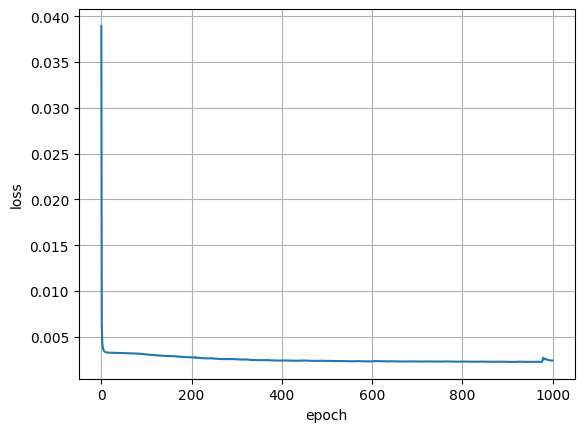

In [45]:
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(losses);

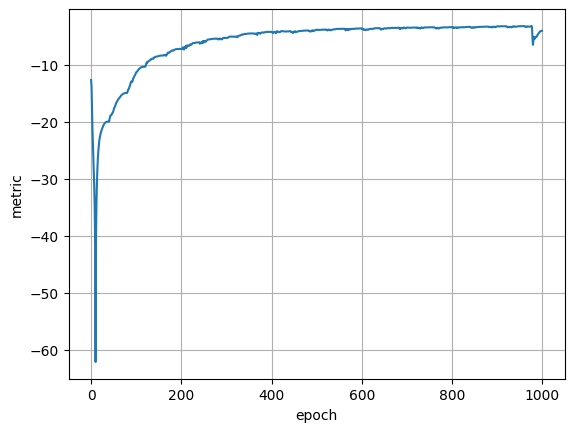

In [46]:
plt.xlabel('epoch')
plt.ylabel('metric')
plt.grid()
plt.plot(metrics);

In [33]:
spec_sample = stft.stft(train_sample[None])
mag = spec_sample.abs()
phase = th.atan2(spec_sample.imag, spec_sample.real)

mask = model_mask(spec_sample)
mag_predict = mag * mask

imag = mag_predict * th.sin(phase)
real = mag_predict * th.cos(phase)

z = th.complex(real, imag)

predict = stft.istft(z, train_sample.shape[-1])

In [47]:
Audio(predict[0].detach(), rate=16000)

In [48]:
Audio(train_sample[0].detach(), rate=16000)

In [49]:
Audio(train_target.detach(), rate=16000)

In [50]:
def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)

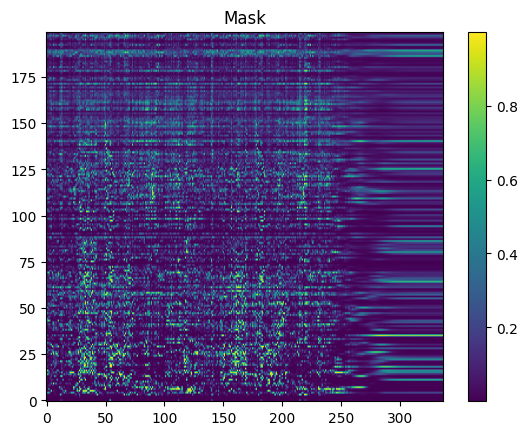

In [51]:
plot_mask(mask.detach()[0])

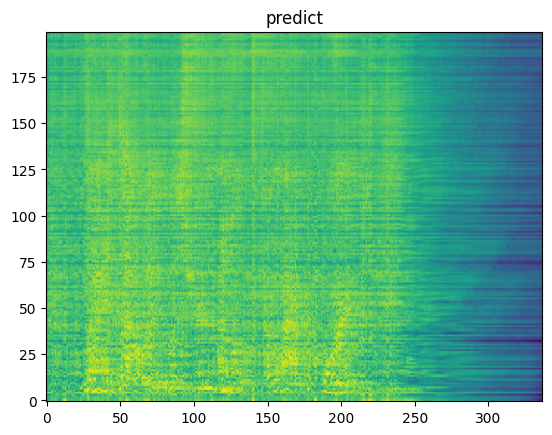

In [53]:
plt.title('predict')
plt.imshow(torch.log(mag_predict).detach()[0], cmap="viridis", origin="lower", aspect="auto");

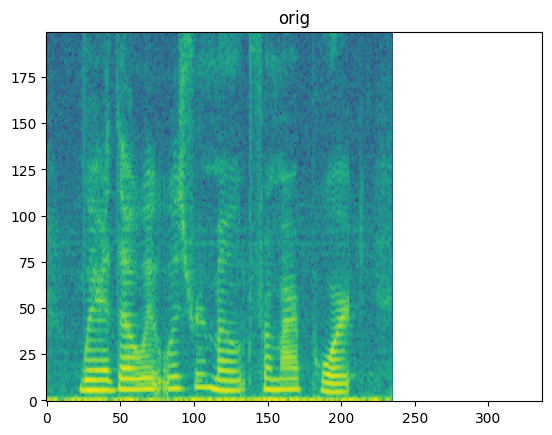

In [54]:
plt.title('orig')
plt.imshow(torch.log(stft.stft(train_target).abs()).detach()[0], cmap="viridis", origin="lower", aspect="auto");

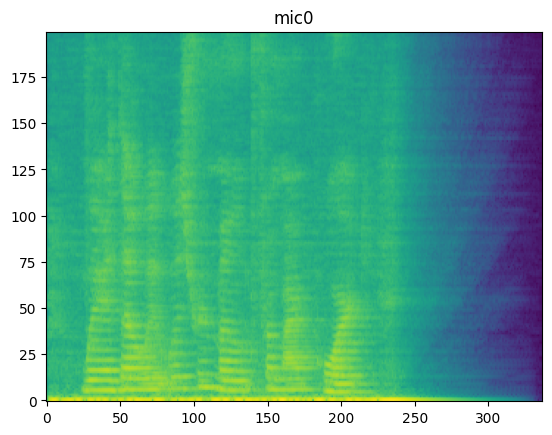

In [56]:
plt.title('mic0')
plt.imshow(torch.log(mag).detach()[0], cmap="viridis", origin="lower", aspect="auto");